In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from RISparser import read, TAG_KEY_MAPPING, LIST_TYPE_TAGS

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files

In [2]:
list_keys = [TAG_KEY_MAPPING[k] for k in LIST_TYPE_TAGS]

def read_ris_to_df(path):
    """Read RIS and return pandas DataFrame"""
    
    # open data and split into lines
    with open(path, "r", encoding="utf-8-sig") as r:
        lines = [line.rstrip("\n") for line in r]
    
    # merge the field with multiple values
    items = []
    for item in read(lines):
        for k, v in item.items():
            if k in list_keys and item[k] is not None:
                item[k] = ";".join(item[k])
        items.append(item)

    return pd.DataFrame(items) 

In [3]:
df_all = read_ris_to_df("raw/Virus_Metagenomics_in_Farm_Animals-ALL.txt")
df_included = read_ris_to_df("raw/Virus_Metagenomics_in_Farm_Animals-INCLUDED-v2.txt")

## Clean datasets

In [4]:
# retain useful columns
use_col = ["title", "abstract", "keywords", "authors", "year", "doi"]
df_all = df_all[use_col]
df_included = df_included[use_col]

In [5]:
# add label
df_included["included"] = 1
df_all["included"] = 0

In [6]:
# merge datasets
df_merged = df_included.append(df_all, sort=False)

In [7]:
# remove duplicates
df_title = df_merged["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
df_merged = df_merged[(~df_title.str.lower().duplicated()) | (df_title.isnull())]

## Export datasets

In [8]:
Path("output").mkdir(parents=True, exist_ok=True)
df_merged.to_csv("output/Kwok_2020.csv", index=False)

## Dataset statistics

In [9]:
n = len(df_merged)
n_inc = df_merged["included"].sum()
n_exc = n - n_inc

print("Number of papers with missing title:    ", df_merged["title"].isna().sum(), "\n")
print("Number of papers with missing abstract: ", df_merged["abstract"].isna().sum(), "\n")
print("Total number of papers:                 ", n, "\n")
print("Total number of EXCLUSIONS:             ", n_exc, "\n")
print("Total number of INCLUSIONS:             ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Number of papers with missing title:     0 

Number of papers with missing abstract:  176 

Total number of papers:                  2474 

Total number of EXCLUSIONS:              2354 

Total number of INCLUSIONS:              120  ( 4.85 % )



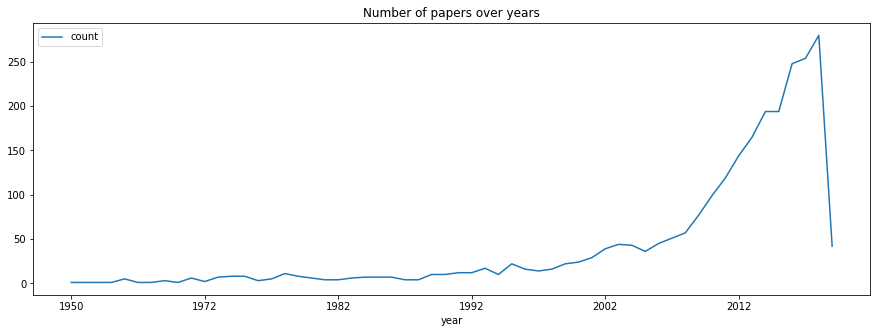

In [10]:
# number of papers over years
df_merged.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

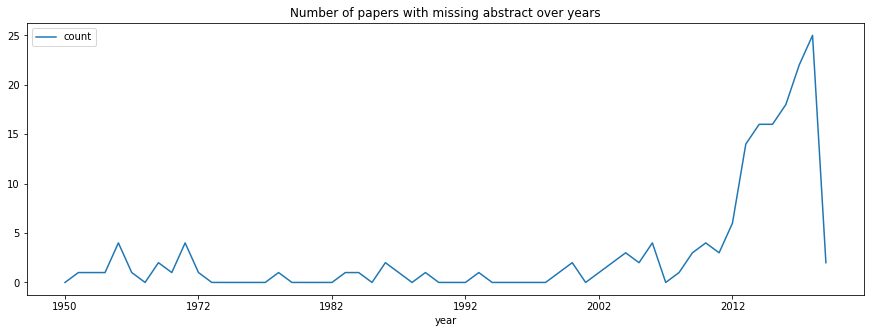

In [11]:
# missing abstract over years
df_merged["abstract"].isna().groupby(df_merged["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

There are 256065 words in the combination of all titles. 

There are 3089473 words in the combination of all abstracts. 



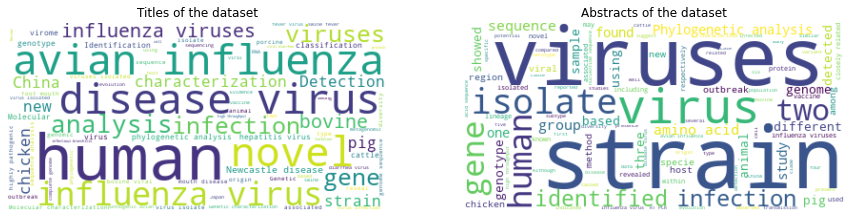

In [12]:
# word cloud for titles and abstracts
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["effect", "effects", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df_merged.title.dropna())
abstract_text = " ".join(word for word in df_merged.abstract.dropna())
print ("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print ("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()